Solution Code Part 1


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# URL of the CSV file
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# Read the CSV file into a DataFrame
df = pd.read_excel(data_url)  # Assuming the data is in Excel format based on the common source

# Convert 'InvoiceDate' to datetime format for time-related features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total bill for each transaction
df['Total_Bill'] = df['Quantity'] * df['UnitPrice']

# Aggregate data at the customer level
customer_df = df.groupby('CustomerID').agg(
    Total_Bill_Size=('Total_Bill', 'sum'),
    First_Purchase=('InvoiceDate', 'min'),
    Last_Purchase=('InvoiceDate', 'max'),
    Most_Common_Location=('Country', lambda x: x.mode()[0]),
    Top_Item=('StockCode', lambda x: x.value_counts().idxmax())
)

# Calculate purchase interval in days
customer_df['Purchase_Interval_Days'] = (customer_df['Last_Purchase'] - customer_df['First_Purchase']).dt.days

# Reset index to have 'CustomerID' as a column
customer_df.reset_index(inplace=True)

# Display the customer-level dataframe
print(customer_df.head())


   CustomerID  Total_Bill_Size      First_Purchase       Last_Purchase  \
0     12346.0             0.00 2011-01-18 10:01:00 2011-01-18 10:17:00   
1     12347.0          4310.00 2010-12-07 14:57:00 2011-12-07 15:52:00   
2     12348.0          1797.24 2010-12-16 19:09:00 2011-09-25 13:13:00   
3     12349.0          1757.55 2011-11-21 09:51:00 2011-11-21 09:51:00   
4     12350.0           334.40 2011-02-02 16:01:00 2011-02-02 16:01:00   

  Most_Common_Location Top_Item  Purchase_Interval_Days  
0       United Kingdom    23166                       0  
1              Iceland    22375                     365  
2              Finland     POST                     282  
3                Italy    23112                       0  
4               Norway    21908                       0  


In [ ]:
# Standardize the 'Total_Bill_Size' feature
scaler = StandardScaler()
customer_df['Total_Bill_Size_Scaled'] = scaler.fit_transform(customer_df[['Total_Bill_Size']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # You may want to adjust the number of clusters based on your analysis
customer_df['Cluster'] = kmeans.fit_predict(customer_df[['Total_Bill_Size_Scaled']])

# Display the first few rows of the dataframe to verify clustering
print(customer_df.head())

   CustomerID  Total_Bill_Size      First_Purchase       Last_Purchase  \
0     12346.0             0.00 2011-01-18 10:01:00 2011-01-18 10:17:00   
1     12347.0          4310.00 2010-12-07 14:57:00 2011-12-07 15:52:00   
2     12348.0          1797.24 2010-12-16 19:09:00 2011-09-25 13:13:00   
3     12349.0          1757.55 2011-11-21 09:51:00 2011-11-21 09:51:00   
4     12350.0           334.40 2011-02-02 16:01:00 2011-02-02 16:01:00   

  Most_Common_Location Top_Item  Purchase_Interval_Days  \
0       United Kingdom    23166                       0   
1              Iceland    22375                     365   
2              Finland     POST                     282   
3                Italy    23112                       0   
4               Norway    21908                       0   

   Total_Bill_Size_Scaled  Cluster  
0               -0.231001        0  
1                0.293432        0  
2               -0.012316        0  
3               -0.017146        0  
4              

In [ ]:
# Function to summarize cluster information with improved readability
def summarize_cluster_info(clustered_df):
    for i in range(kmeans.n_clusters):
        cluster_data = clustered_df[clustered_df['Cluster'] == i]
        print(f"\nCluster {i} Summary:")

        # Customer count in each cluster
        customer_count = len(cluster_data)
        print(f"Number of Customers in the cluster: {customer_count}")

        # Average spend in each cluster
        avg_spend = cluster_data['Total_Bill_Size'].mean()
        print(f"Average Spend: ${avg_spend:.2f}")

        # Top 3 Locations with counts
        top_locations = cluster_data['Most_Common_Locations'].value_counts().head(3)
        print("Top 3 Locations:")
        for location, count in top_locations.items():
            print(f"{location}: {count} customers")

        # Top 3 Items with counts
        top_items = cluster_data['Top_Item'].value_counts().head(3)
        print("Top 3 Item Codes:")
        for item, count in top_items.items():
            print(f"{item}: {count} times purchased")

# Call the function to display the summary
summarize_cluster_info(customer_df)


Cluster 0 Summary:
Number of Customers: 4346
Average Spend: $1434.20
Top 3 Locations:
United Kingdom: 3929 customers
Germany: 95 customers
France: 87 customers
Top 3 Items:
POST: 127 times purchased
85123A: 92 times purchased
22423: 90 times purchased
Average Purchase Interval: 132.11 days

Cluster 1 Summary:
Number of Customers: 3
Average Spend: $241136.56
Top 3 Locations:
United Kingdom: 2 customers
Netherlands: 1 customers
Top 3 Items:
22629: 1 times purchased
22470: 1 times purchased
22189: 1 times purchased
Average Purchase Interval: 359.33 days

Cluster 2 Summary:
Number of Customers: 23
Average Spend: $58418.75
Top 3 Locations:
United Kingdom: 19 customers
EIRE: 2 customers
Australia: 1 customers
Top 3 Items:
22197: 4 times purchased
C2: 2 times purchased
22630: 1 times purchased
Average Purchase Interval: 344.74 days


Complete Code Part 2

Silhouette Coefficient: 0.70
Cluster counts:
Cluster
 0    4337
 1      16
-1      12
 2       7
Name: count, dtype: int64
Noise points count: 12


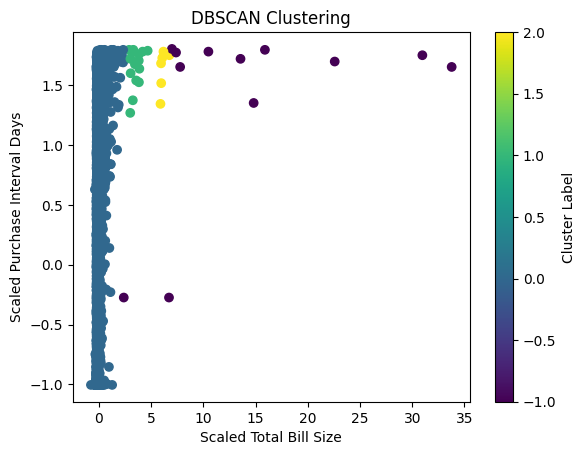


Cluster 0 Summary:
Number of Customers: 4337
Average Total Bill: 1381.65
Average Purchase Interval: 131.72

Cluster 1 Summary:
Number of Customers: 16
Average Total Bill: 30720.77
Average Purchase Interval: 353.69

Cluster 2 Summary:
Number of Customers: 7
Average Total Bill: 52637.10
Average Purchase Interval: 353.00


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the data
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(data_url)

# Preprocess the data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Total_Bill'] = df['Quantity'] * df['UnitPrice']
customer_df = df.groupby('CustomerID').agg(
    Total_Bill_Size=('Total_Bill', 'sum'),
    Purchase_Interval_Days=('InvoiceDate', lambda x: (x.max() - x.min()).days)
).reset_index()

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(customer_df[['Total_Bill_Size', 'Purchase_Interval_Days']])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(features)

# Add clusters back to the dataframe
customer_df['Cluster'] = clusters

# Display clustering results
print("Cluster counts:")
print(customer_df['Cluster'].value_counts())

# Identify and display noise points
noise = customer_df[customer_df['Cluster'] == -1]
print(f"Noise points count: {len(noise)}")

# Visualizing the results
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Scaled Total Bill Size')
plt.ylabel('Scaled Purchase Interval Days')
plt.colorbar(label='Cluster Label')
plt.show()

# Summary of results
def summarize_clusters(df):
    grouped = df.groupby('Cluster')
    for key, group in grouped:
        if key == -1:
            continue  # Skip the noise points for detailed summary
        print(f"\nCluster {key} Summary:")
        print(f"Number of Customers: {len(group)}")
        avg_bill = group['Total_Bill_Size'].mean()
        avg_interval = group['Purchase_Interval_Days'].mean()
        print(f"Average Total Bill: {avg_bill:.2f}")
        print(f"Average Purchase Interval: {avg_interval:.2f}")

summarize_clusters(customer_df)
